In [6]:
from math import trunc

import pandas as pd
from numpy import cov

from statsforecast import StatsForecast as sf
from statsforecast.models import MSTL
from datasetsforecast.m4 import M4

import seaborn as sb
import matplotlib.pyplot as plt

### Data
---
Load in M4 data. M4 is a collection of different time series data. They are uniquely identified by their `unique_id`. Just pick a few to work with. I wish there was context to this data.

* `ds` is the timestamp. Hourly in my case.
* `y` is the value at that timestamp.
* `unique_id` is the time series dataset id.

In [7]:
df_all, *_ = M4.load('./data', 'Hourly')

In [8]:
# Turns the timestamp into integers so it's easier to work with.
df_all['ds'] = df_all['ds'].astype(int)

# Just pick out the first few datasets to work with.
n_series = 8
uids = df_all['unique_id'].unique()[:n_series]
df = df_all.query('unique_id in @uids')

### Time Plot
---
The usual plotting you think would happen.

<Axes: xlabel='ds', ylabel='y'>

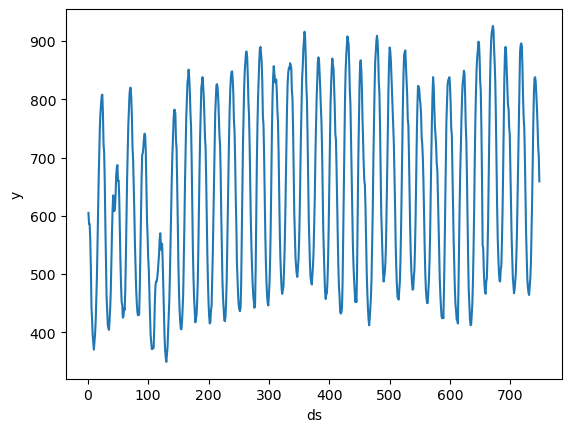

In [9]:
# You must copy after a you slice into teh dataframe since these are 'views' rather than 'tables'.
sub_df = df.query("unique_id == 'H1'").copy()

sb.lineplot(data=sub_df, x='ds', y='y')

### Seasonal Plot
---
Have to manually do all the tables and shit. Bleh. But, it's not that bad.

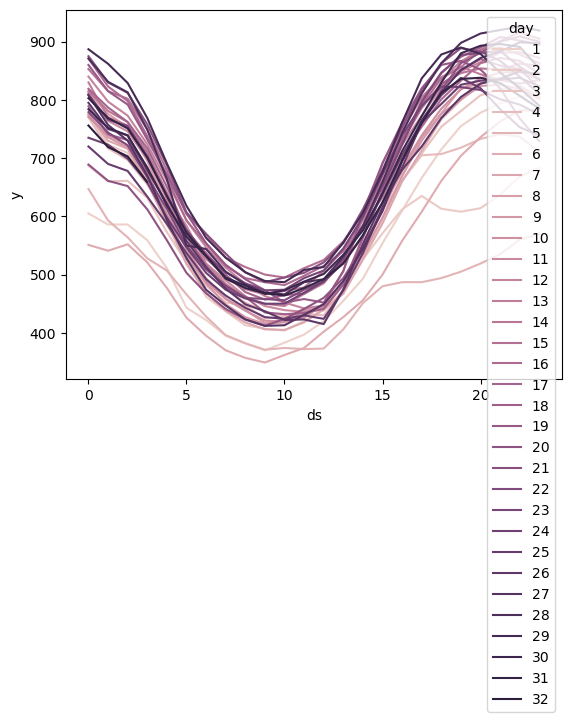

In [10]:
# Calculate the days.
sub_df['day'] = ((sub_df['ds'] - 1)/24 + 1).apply(trunc)
# Make the hours loop so the days can be put ontop of each other.
sub_df['ds'] = (sub_df['ds'] - 1) % 24

pretty_args = {'legend': 'full'}
s_plot = sb.lineplot(data=sub_df, x='ds', y='y', hue='day', **pretty_args)

### Seasonal Subseries Plot
---
Can't do it lol.

In [11]:
# fig, axs = plt.subplots(nrows=16, ncols=2)
 
# for i in range(31):
#     season_df = sub_df.loc[24*i:24*i + 23, :]
#     sb.lineplot(data=season_df, x='ds', y='y', ax=axs[i % 16][i % 2])

### Scatter Plot
---
Good for finding relationships between two time series.

<Axes: xlabel='y_H1', ylabel='y_H10'>

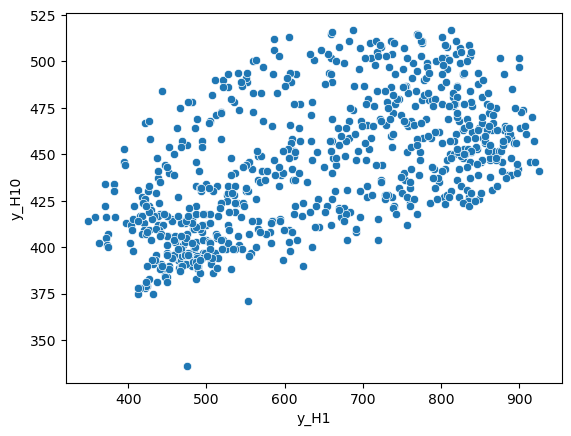

In [12]:
ds_H10 = df.query("unique_id == 'H10'")
ds_combined = df.query("unique_id == 'H1'").copy().rename(columns={'y': 'y_H1'}).assign(**{'y_H10': ds_H10['y'].to_list()})

sb.scatterplot(data=ds_combined, x='y_H1', y='y_H10')

### Lag Plot
---
Good for comparison a time series to itself over some seaons.

Note: Okay I got it working, but I needed to use `matplotlib`. Bleh. Sucks, but I think I'll just need to learn both.

0.9614790833376659
1.010959426372899
1.003628217555972
0.9122585332764535


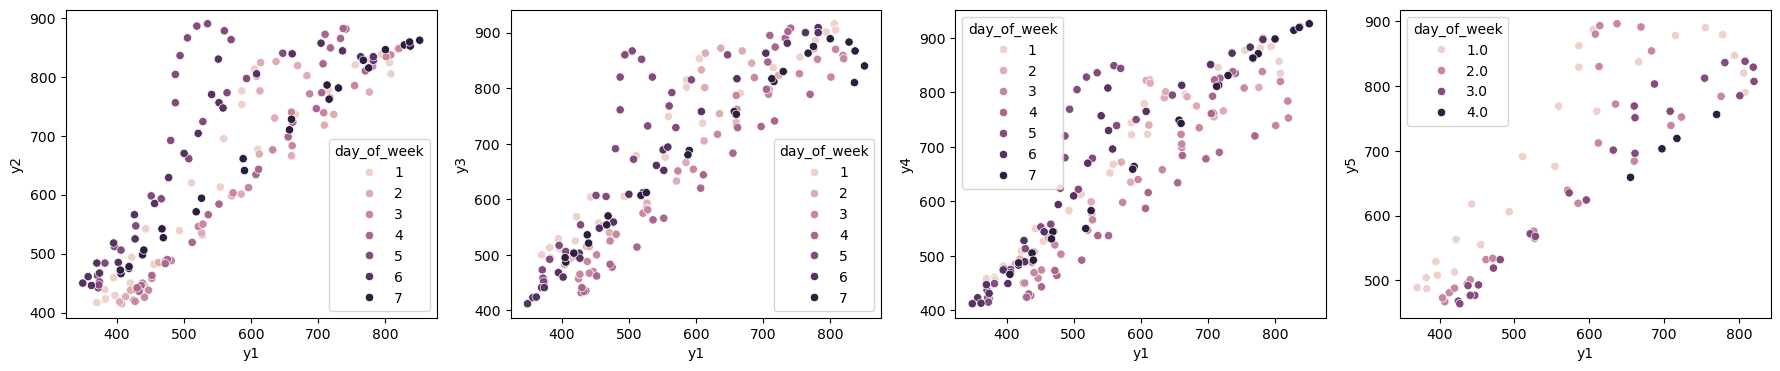

In [23]:
# Covariance calculations.
covs = []

# Generate weeks from the days.
df_H1 = df.query("unique_id == 'H1'").copy().rename(columns={'ds': 'hour'})
df_H1['day'] = ((df_H1['hour'] - 1)/24).map(trunc) + 1
df_H1['week'] = ((df_H1['day'] - 1)/7).map(trunc) + 1

# Get the number of weeks to lag plot them.
weeks = df_H1['week'].unique().tolist()
weeks.remove(1)

df_H1['day_of_week'] = (df_H1['day'] - 1) % 7 + 1

# Fix the first week to lag from the rest of the weeks.
df_fixed_week = df_H1.query("week == 1").rename(columns={'y': 'y1'}).drop(columns=['unique_id', 'day', 'hour', 'week', 'day_of_week'])

f, axs = plt.subplots(1, 4, figsize=(22,4))

# Loop through every week=2,3,4,5 and plot against week=1.
for week in weeks:
    df_H1_weeked = df_H1.query(f'week == {week}').reset_index(drop=True).drop(columns=['unique_id', 'hour', 'day', 'week']).rename(columns={'y': f'y{week}'})
    
    df_H1_merged = pd.concat([df_fixed_week, df_H1_weeked], axis=1)
    
    # Calculate the autocorrelation between the first week and the rest of the weeks, one by one.
    cov_mat = cov(df_H1_merged[['y1', f'y{week}']][~df_H1_merged.isnull().any(axis=1)].T)   
    auto_corr = cov_mat[0, 1]/cov_mat[0, 0]
    covs.append(auto_corr)
    
    plot = sb.scatterplot(data=df_H1_merged, x='y1', y=f'y{week}', hue='day_of_week', ax=axs[week-2])

### Autocorrelation Plot
---
The spread of the joint time steps relative to the spread of the starting point variance.

$$r_k=\frac{\mathbb{C}ov[y_t,y_{t-k}]}{\mathbb{V}[y_t]}$$

Look likes like ass since `seaborn` doesn't readily do this.

<Axes: xlabel='0', ylabel='1'>

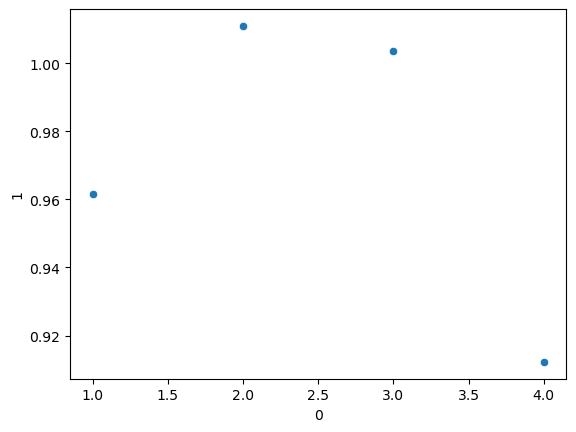

In [30]:
ind_covs = zip(range(1,5), covs)
df_covs = pd.DataFrame(ind_covs)

sb.scatterplot(data=df_covs, x=0, y=1)